CNN Experiments 

cpu

Training model 1 with config: {'channels': [32, 64, 128]}
Epoch 1/10 | Train Loss: 1.2046 | Test Loss: 0.9974 | Accuracy: 65.15%
Epoch 2/10 | Train Loss: 0.8082 | Test Loss: 0.8421 | Accuracy: 71.55%
Epoch 3/10 | Train Loss: 0.6701 | Test Loss: 0.7153 | Accuracy: 75.22%
Epoch 4/10 | Train Loss: 0.5638 | Test Loss: 0.6567 | Accuracy: 77.72%
Epoch 5/10 | Train Loss: 0.4761 | Test Loss: 0.7122 | Accuracy: 76.19%
Epoch 6/10 | Train Loss: 0.3996 | Test Loss: 0.6759 | Accuracy: 77.10%
Epoch 7/10 | Train Loss: 0.3259 | Test Loss: 0.7302 | Accuracy: 77.21%
Epoch 8/10 | Train Loss: 0.2669 | Test Loss: 0.7374 | Accuracy: 78.36%
Epoch 9/10 | Train Loss: 0.2170 | Test Loss: 0.7857 | Accuracy: 78.64%
Epoch 10/10 | Train Loss: 0.1702 | Test Loss: 0.7723 | Accuracy: 79.07%

Training model 2 with config: {'channels': [64, 128, 256]}
Epoch 1/10 | Train Loss: 1.2224 | Test Loss: 1.0555 | Accuracy: 62.97%
Epoch 2/10 | Train Loss: 0.7961 | Test Loss: 0.7548 | Accuracy: 73.93%
Epoch 3/10 | Train Loss:

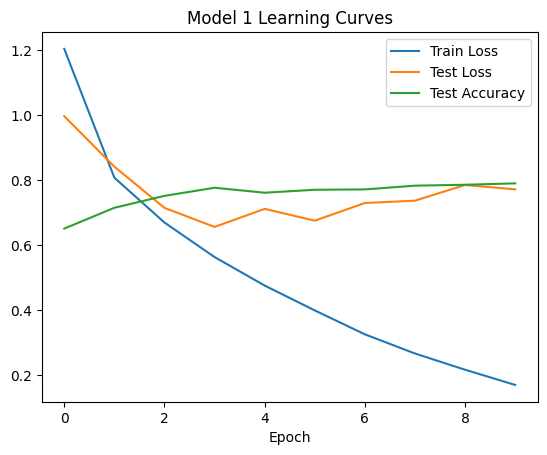

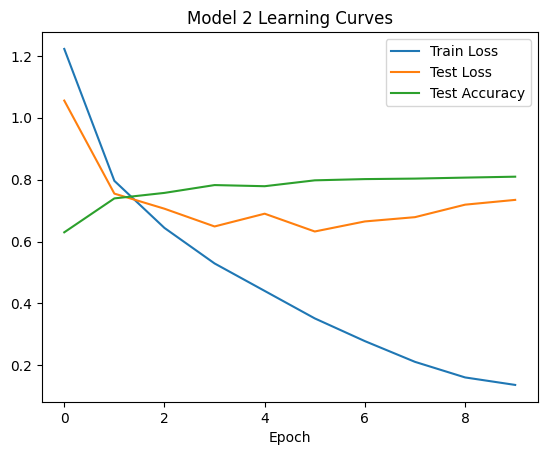

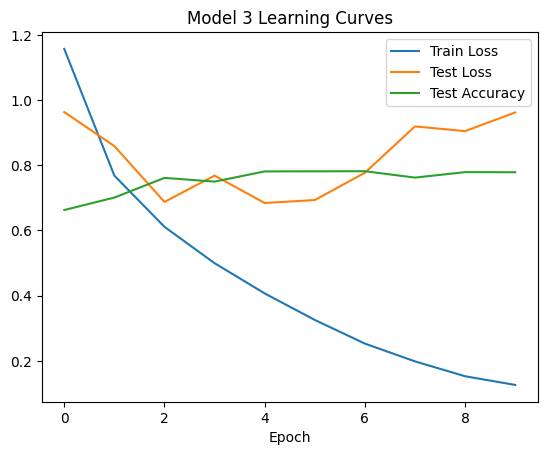

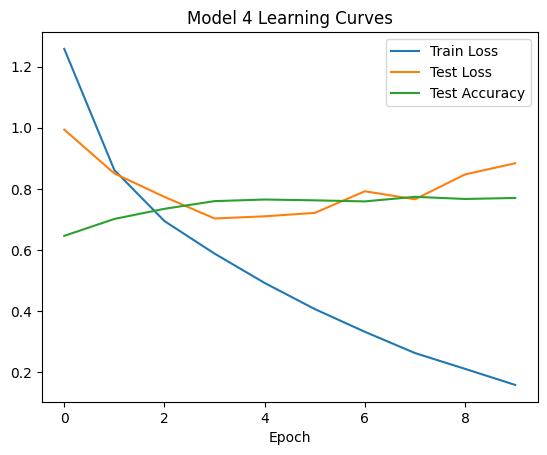

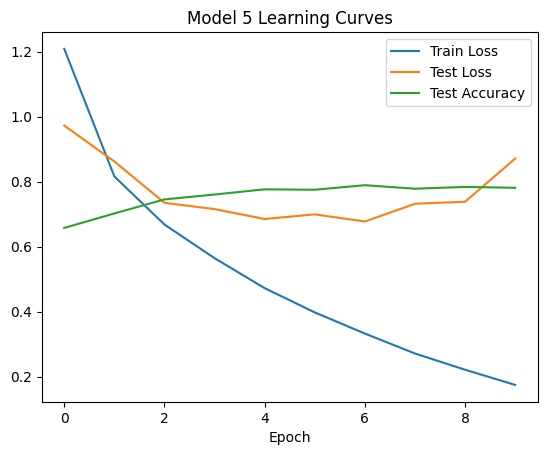

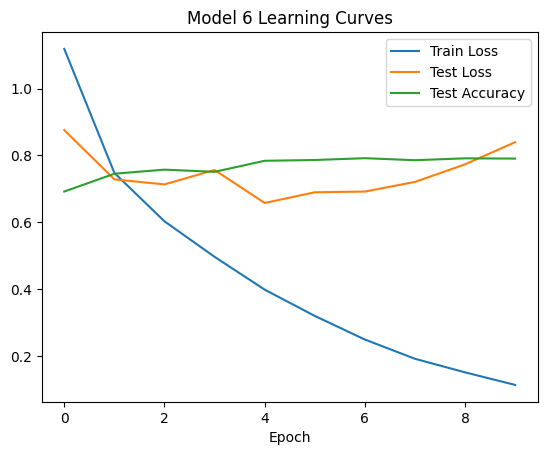

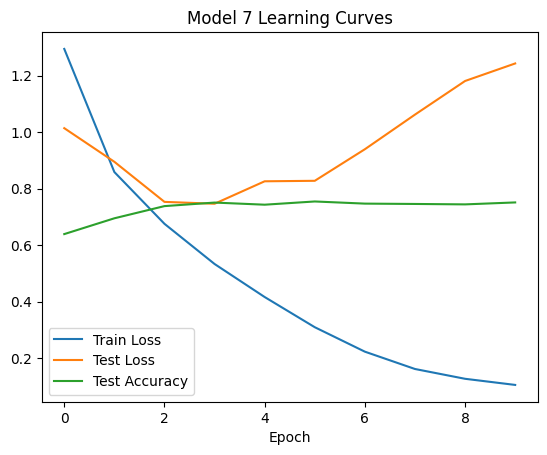

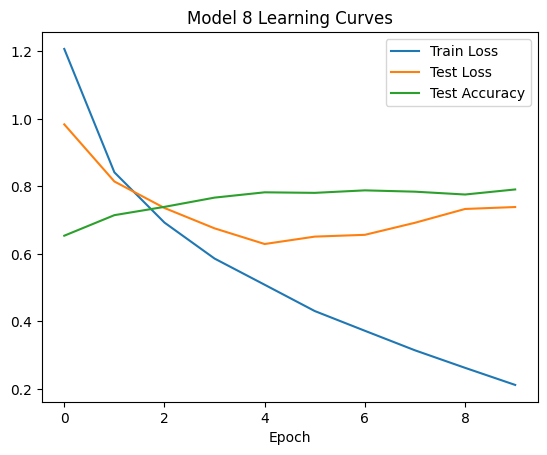

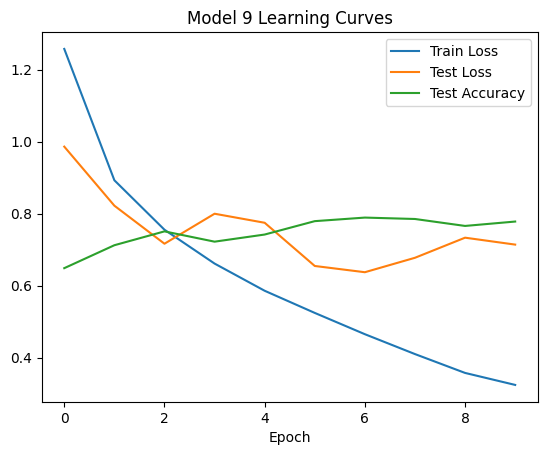

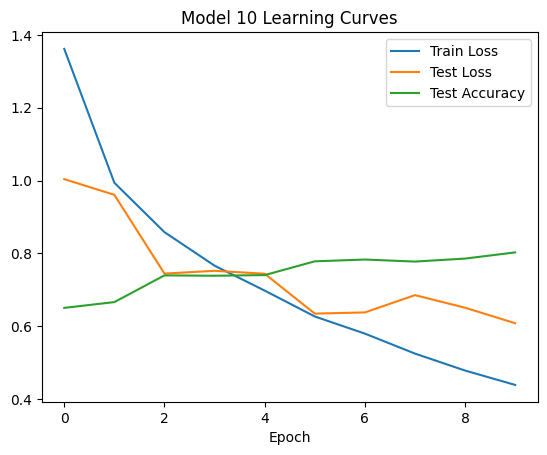

In [ ]:
#import packages

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

#read in CIFAR-10 dataset 
#we must change our dataset loader from what was used in class to adapt to CIFAR-10 and adding normalization 

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2470, 0.2435, 0.2616])
    #standard means and stdv computed from entire dataset 
])

training_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=transform,
)

test_data = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=transform,
)

#device 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
print(device) 

#create data loaders 
batch_size = 64
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

#create model 
#create a configurable CNN 
class CNN(nn.Module): 
    def __init__(self, 
                 channels=[32, 64, 128], #number of filters per convolution block
                 kernel_size=3, #kernel size
                 activation=nn.ReLU, #our activation function (standard) 
                 use_bn=True, pool_type="max", #whether to use batch normalization 
                 dropout=0.0, #dropout probability 
                 stride = 1): #number of pixels by which kernel moves accross input image 
        super().__init__() 

        layers = []
        in_ch = 3 

        #feature extractor 
        for out_ch in channels: 

            #convolution
            layers.append(nn.Conv2d(
                in_channels=in_ch,
                out_channels=out_ch,
                kernel_size=kernel_size,
                stride = stride,
                padding=kernel_size//2  
            ))

            if use_bn: 
                layers.append(nn.BatchNorm2d(out_ch))

            #application of non-linearity 
            layers.append(activation())

            #pooling
            #we can't pool with stride greater than 1, because that would over-compress spatial information 
            #never ended up experimenting with stride, but kept this in here nonetheless, because I thought it was a cool preventative measure 
            if stride == 1: 
                if pool_type == "max": 
                    layers.append(nn.MaxPool2d(2))
                elif pool_type == "avg": 
                    layers.append(nn.AvgPool2d(2))

            #making output channels the input channels for our next block 
            in_ch = out_ch 

        #combining all convolutional layers into one module 
        self.feature_extractor = nn.Sequential(*layers) 

        #halving our spatial dimension after each pool 
        #i.e. 32 -> 16 -> 8 -> 4 for 3 convolution blocks 
        size = 32
        for _ in channels: 
            size = size // stride 
            if pool_type in ["max", "avg"]:
                size = size // 2 
        final_size = size 

        self.classifier = nn.Sequential(
            nn.Flatten(), #(64, 128, 4, 3) -> (64, 2048) 
            nn.Linear(channels[-1] * final_size * final_size, 512), #(64, 2048) -> (64, 512)
            nn.ReLU(),
            nn.Dropout(dropout), #adding dropout to prevent overfitting 
            nn.Linear(512, 10) #10 CIFAR-10 classes 
        )
    
    def forward(self, x): 
        #pass image through convolutional feature extractor 
        x = self.feature_extractor(x) 

        #pass extracted features into classifier 
        x = self.classifier(x) 

        return x

def train(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss

def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            logits = model(images)
            loss = criterion(logits, labels)
            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(logits, 1)
            correct += (preds == labels).sum().item()
    epoch_loss = running_loss / len(dataloader.dataset)
    accuracy = correct / len(dataloader.dataset)
    return epoch_loss, accuracy

#list of our desired experiments 
experiments = [
    {"channels":[32,64,128]},
    {"channels":[64,128,256]},
    {"channels":[32,64,128,256]},
    {"kernel_size":5},
    {"activation":nn.LeakyReLU},
    {"activation":nn.GELU},
    {"use_bn":False},
    {"pool_type":"avg"},
    {"dropout":0.3},
    {"dropout":0.5},
]

#training and evaluation of the model
criterion = nn.CrossEntropyLoss()

#run experiments 
num_epochs = 10
all_histories = []
for i, config in enumerate(experiments):
    print(f"\nTraining model {i+1} with config: {config}")

    model = CNN(**config).to(device) #**config let's us use the same model class by unpacking our keyword argument 
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    history = {
        "train_loss": [],
        "test_loss": [],
        "test_acc": []
    }

    for epoch in range(num_epochs):
        train_loss = train(model, train_dataloader, criterion, optimizer, device)
        test_loss, test_acc = evaluate(model, test_dataloader, criterion, device)

        history["train_loss"].append(train_loss)
        history["test_loss"].append(test_loss)
        history["test_acc"].append(test_acc)

        print(f"Epoch {epoch+1}/{num_epochs} | " f"Train Loss: {train_loss:.4f} | "f"Test Loss: {test_loss:.4f} | "f"Accuracy: {test_acc*100:.2f}%")

    all_histories.append(history)


import matplotlib.pyplot as plt
#plotting train loss, test loss, and test accuracy for each model 
for i, hist in enumerate(all_histories):
    plt.figure()
    plt.plot(hist["train_loss"], label="Train Loss")
    plt.plot(hist["test_loss"], label="Test Loss")
    plt.plot(hist["test_acc"], label="Test Accuracy")
    plt.title(f"Model {i+1} Learning Curves")
    plt.xlabel("Epoch")
    plt.legend()
    plt.show()



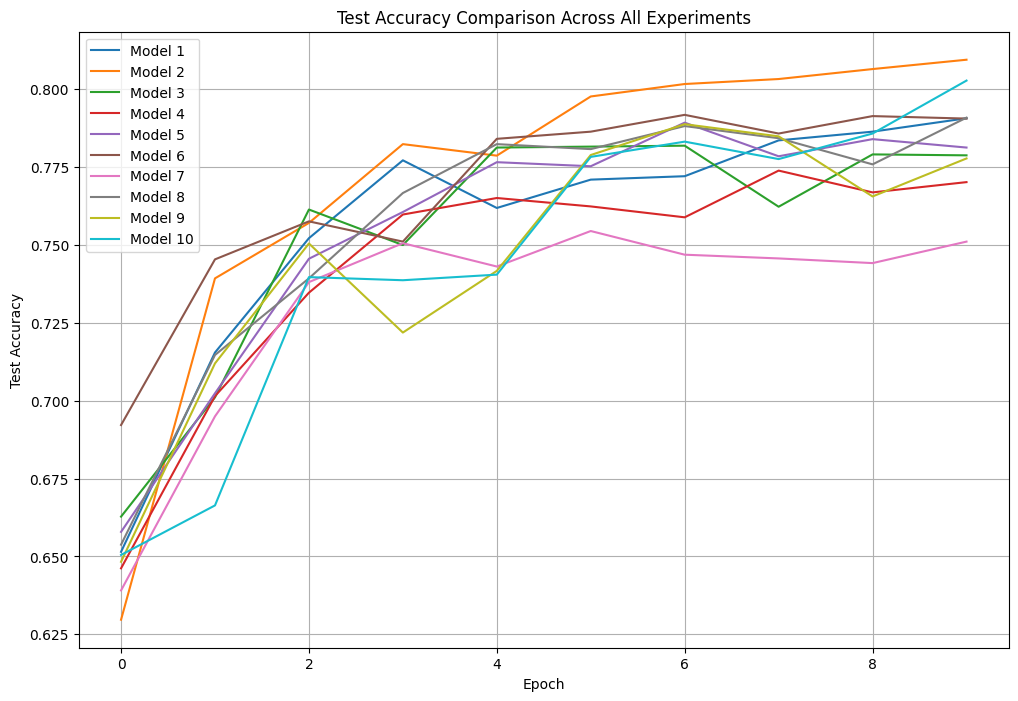

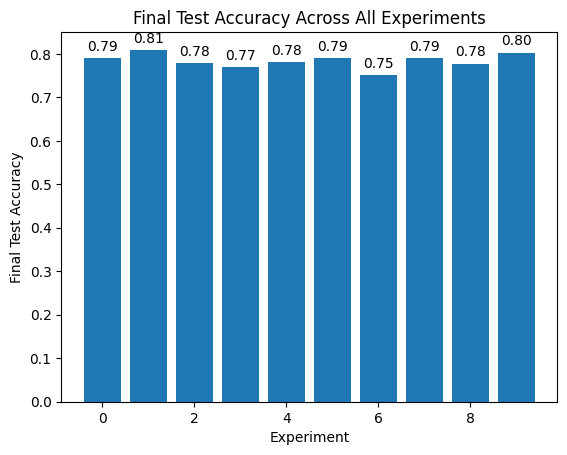

In [17]:
#more plots 

#line graph comparing test accuracies accross all experiments and epochs 
plt.figure(figsize=(12, 8))

for i, hist in enumerate(all_histories):
    plt.plot(hist["test_acc"],label=f"Model {i+1}")

plt.title("Test Accuracy Comparison Across All Experiments")
plt.xlabel("Epoch")
plt.ylabel("Test Accuracy")
plt.legend()
plt.grid(True)
plt.show()

#bar graph comparing final test accuracies accross all experiments 
final_acc = [hist["test_acc"][-1] for hist in all_histories]
plt.bar(range(len(final_acc)), final_acc)
plt.xticks
plt.xlabel("Experiment")
plt.ylabel("Final Test Accuracy") 
plt.title("Final Test Accuracy Across All Experiments")
for i, acc in enumerate(final_acc):
    plt.text(i, acc + 0.01, f"{acc:.2f}", ha="center", va="bottom")






In [ ]:
#MLP
#Using a very similar one that was used in class 

class MLP(nn.Module):
    # initialize the layers
    def __init__(self):
        #call the init function of the parent class nn.Module
        super().__init__()
        #define the layers
        self.flatten = nn.Flatten() #CIFAR-10 images are (3, 32, 32), so 3 x 32 x 32 = 3072 : (64, 3, 32, 32) --> (64, 3072) 
        #hidden layers with ReLU activations
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(3*32*32, 512), 
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 10),
        )

    # define the forward pass
    def forward(self, x):
        # flatten the input tensor
        x = self.flatten(x)
        # pass through the layers
        logits = self.linear_relu_stack(x)
        # return the logits
        return logits

mlp_model = MLP().to(device) 
print(mlp_model) 
mlp_optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)

mlp_history = {
    "train_loss": [],
    "test_loss": [],
    "test_acc": []
}

num_epochs = 10
for epoch in range(num_epochs):
    mlp_train_loss = train(mlp_model, train_dataloader, criterion, mlp_optimizer, device)
    mlp_test_loss, mlp_test_accuracy = evaluate(mlp_model, test_dataloader, criterion, device)

    mlp_history["train_loss"].append(mlp_train_loss)
    mlp_history["test_loss"].append(mlp_test_loss)
    mlp_history["test_acc"].append(mlp_test_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {mlp_train_loss:.4f}, Test Loss: {mlp_test_loss:.4f}, Test Accuracy: {mlp_test_accuracy*100:.4f}%")



MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=3072, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=10, bias=True)
  )
)
Epoch 1/10, Train Loss: 1.6607, Test Loss: 1.5202, Test Accuracy: 46.4400%
Epoch 2/10, Train Loss: 1.4659, Test Loss: 1.4768, Test Accuracy: 47.6200%
Epoch 3/10, Train Loss: 1.3661, Test Loss: 1.4373, Test Accuracy: 49.4700%
Epoch 4/10, Train Loss: 1.2828, Test Loss: 1.4521, Test Accuracy: 49.7100%
Epoch 5/10, Train Loss: 1.2089, Test Loss: 1.4123, Test Accuracy: 51.1500%
Epoch 6/10, Train Loss: 1.1470, Test Loss: 1.4381, Test Accuracy: 52.1900%
Epoch 7/10, Train Loss: 1.0787, Test Loss: 1.4246, Test Accuracy: 51.6400%
Epoch 8/10, Train Loss: 1.0191, Test Loss: 1.5001, Test Accuracy: 52.1900%
Epoch 9/10, Train Loss: 0.9575, Test Loss: 1.4937, Test Accuracy: 51.6200%
Epoch 10/10, Tr

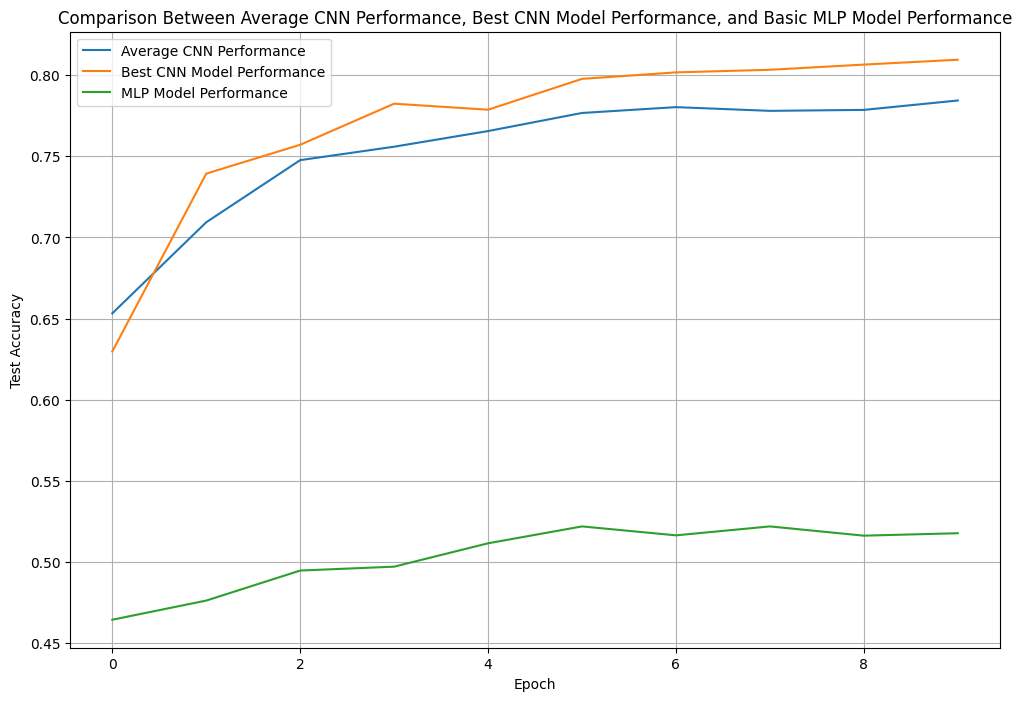

In [24]:
#plot CNN average test accuracy per epoch vs. max final test accuracy experiment per epoch vs. MLP test accuracy per epoch

cnn_avg_per_epoch = [(sum(hist["test_acc"][epoch] for hist in all_histories)) / len(all_histories) for epoch in range(num_epochs)] #calculating the average accuracy per epoch of each model
best_cnn_idx = max(range(len(all_histories)), key=lambda i: all_histories[i]["test_acc"][-1]) #index of the model that had the best final test accuracy
best_cnn_history = all_histories[best_cnn_idx]["test_acc"] #history of the model with best final accuracy

plt.figure(figsize=(12, 8))

plt.plot(cnn_avg_per_epoch,label="Average CNN Performance")
plt.plot(best_cnn_history,label="Best CNN Model Performance")
plt.plot(mlp_history["test_acc"],label="MLP Model Performance")

plt.title("Comparison Between Average CNN Performance, Best CNN Model Performance, and Basic MLP Model Performance")
plt.xlabel("Epoch")
plt.ylabel("Test Accuracy")
plt.legend()
plt.grid(True)
plt.show()
